# [문자-단위 RNN으로 이름 생성](https://tutorials.pytorch.kr/intermediate/char_rnn_generation_tutorial.html)

# 1.데이터 준비

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # EOS(end of sentence) 기호 추가

def findFiles(path): return glob.glob(path)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

In [ ]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [ ]:
DATA_PATH = "/content/data/MyDrive/lecture/6. deep learning/7-2. NLP_Pytorch/data/"

In [ ]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []
for filename in glob.glob(DATA_PATH+'names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['German', 'Spanish', 'Greek', 'Chinese', 'Portuguese', 'Scottish', 'Korean', 'Vietnamese', 'English', 'Russian', 'French', 'Polish', 'Arabic', 'Irish', 'Dutch', 'Japanese', 'Czech', 'Italian']
O'Neal


# 2.네트워크 생성

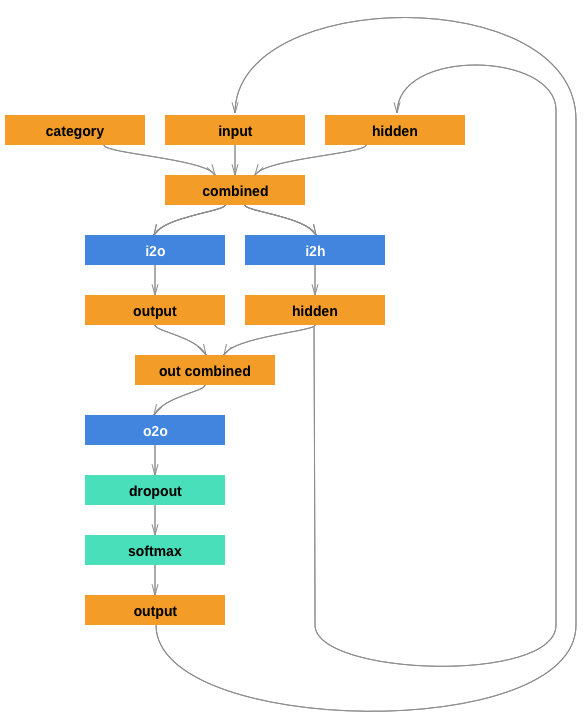

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# 3.학습

## 학습 준비

In [ ]:
import random

# 목록에서 무작위 아이템 반환
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 임의의 category 및 그 category에서 무작위 줄(이름) 얻기
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

각 단계 마다 네트워크의 입력은 `(언어, 현재 문자, 은닉 상태)`가 되고, 출력은 `(다음 문자, 다음 은닉 상태)`가 된다.   
  
언어(Category) Tensor는 `<1 x n_categories>` 크기의 One-hot Tensor입니다. 

In [ ]:
# Category를 위한 One-hot 벡터
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 입력을 위한 처음부터 마지막 문자(EOS 제외)까지의  One-hot 행렬
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 목표를 위한 두번째 문자 부터 마지막(EOS) 까지의 LongTensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

학습 동안 무작위로 (category(언어), line(이름))을 가져오고 그것을 필요한 형태(category(언어), input(현재 문자), target(다음 문자)) tensor로 바꾸는 함수를 만듭니다.

In [ ]:
# 임의의 Category에서 Category, Input, Target Tensor를 만듭니다.
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## 네트워크 학습

In [ ]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(rnn, category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

학습에 걸리는 시간을 추적하기 위한 함수 생성

In [ ]:
import time
import math

def timeSince(since):
  
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # plot_every 마다 초기화

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(rnn, *randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 16s (5000 5%) 2.8348
0m 30s (10000 10%) 2.8890
0m 45s (15000 15%) 2.6675
1m 0s (20000 20%) 2.1834
1m 15s (25000 25%) 2.7234
1m 31s (30000 30%) 2.1399
1m 45s (35000 35%) 2.6446
2m 0s (40000 40%) 2.7480
2m 14s (45000 45%) 1.7395
2m 30s (50000 50%) 2.8895
2m 44s (55000 55%) 2.6513
2m 59s (60000 60%) 2.1443
3m 13s (65000 65%) 2.3145
3m 28s (70000 70%) 2.9537
3m 42s (75000 75%) 2.4120
3m 56s (80000 80%) 2.4915
4m 11s (85000 85%) 3.0954
4m 25s (90000 90%) 2.5502
4m 41s (95000 95%) 2.1712
4m 56s (100000 100%) 2.3610


## 손실 도식화

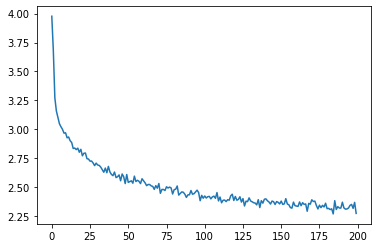

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# plt.figure()
plt.plot(all_losses)
plt.show()

# 4.네트워크 샘플링

In [ ]:
# 카테고리와 시작 문자로 부터 샘플링 하기
def sample(category, start_letter='A', max_length=20):
    with torch.no_grad():  # 샘플링에서 히스토리를 추적할 필요 없음
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [ ]:
# 하나의 카테고리와 여러 시작 문자들로 여러 개의 샘플 얻기
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [ ]:
samples('Russian', 'RUS')
print('-'*50)
samples('German', 'GER')
print('-'*50)
samples('Spanish', 'SPA')
print('-'*50)
samples('Chinese', 'CHI')

Roshillov
Uantovav
Shaverin
--------------------------------------------------
Gerter
Erenge
Roune
--------------------------------------------------
Salla
Parera
Allan
--------------------------------------------------
Chan
Hou
Iun
